# Simulated LSST detections of 2019 OK

**WARNING: WORK IN PROGRES**

We simulated the hypothetical observations of 2019 OK with the Simonyi telescope operating on the LSST cadence in the timespan from the year 1946 to 2117.

Caveats:
* No losses due to gaps were applied (but the overall camera shape has been taken into account)
* No fading function
* No trailing losses taken into account for magnitude computation

## Sims

Simulated observations generated by Sam Cornwall, using the "171 yr run" built by Lynne Jones & Joachim Moeyens:

In [1]:
import pandas as pd
from astropy.time import Time

In [2]:
cols = open("2019OK.dat").readline().split()
ast = pd.read_fwf("2019OK.dat", sep=" ", index_col="FieldID", header=None, skiprows=1, names=cols)
ast[:1]

,ObjID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Sun-Ast-Obs(deg),V,Filtermag,V(H=0),Filter
FieldID,,,,,,,,,,,,,,,,
16658833,S2019OK,57798.382153,4.286812e+07,5.919,205.726176,-1.86648,-14.047123,0.621748,-1.594176e+08,5.846502e+07,22763965.87,50.411326,22.753,23.148,-0.547,g


Convert to human readable time:

In [3]:
ast["t"] = Time(ast["FieldMJD"], format='mjd').datetime

Total number of detections (over 171 years):

Total number of observations: 128


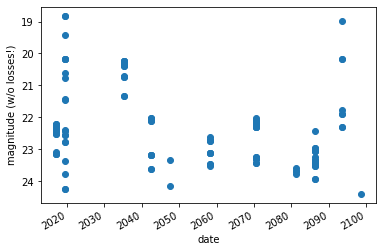

In [4]:
import datetime
import matplotlib.pyplot as plt
plt.plot_date(ast["t"], ast["Filtermag"])
plt.gcf().autofmt_xdate()
plt.xlabel("date")
plt.ylabel("magnitude (w/o losses!)")
plt.gca().invert_yaxis()
print(f"Total number of observations: {len(ast)}")

Grab additional visit data (seeing, m5) and merge into the dataframe:

In [5]:
import pickle
import os.path

surveyFn = '171year.20200515.pkl'

# memoization: querying a giant sqlite database takes awhile, so we'll do it
# once and cache the result
if not os.path.exists(surveyFn):
    print(f"Loading from database... This may take awhile.")
    import pandas as pd
    import sqlite3
    con = sqlite3.connect("impactor_catalog/ver2/171year.db")
    survey = pd.read_sql_query(
            """
            select
                observationId,
                fieldRa as ra, fieldDec as dec,
                observationStartMJD + visitTime/2 as mjd,
                filter, visitTime, visitExposureTime, 
                seeingFwhmEff, seeingFwhmGeom as fwhmGeom, fiveSigmaDepth as m5
            from
                summaryallprops
            """,
            con, index_col="observationId"
        )
    with open(surveyFn, "wb") as fp:
        pickle.dump(survey, fp, protocol=4)
    del con
else:
    print(f"Loading from cache ({surveyFn})...")
    with open(surveyFn, "rb") as fp:
        survey = pickle.load(fp)
    print("done.")

Loading from cache (171year.20200515.pkl)...
done.


In [6]:
survey.iloc[:1]

,ra,dec,mjd,filter,visitTime,visitExposureTime,seeingFwhmEff,fwhmGeom,m5
observationId,,,,,,,,,
1,305.088793,-24.889283,32130.016794,z,34.0,30.0,0.691843,0.620695,23.348592


In [7]:
df = ast.join(survey)
df.iloc[:2]

,ObjID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),...,t,ra,dec,mjd,filter,visitTime,visitExposureTime,seeingFwhmEff,fwhmGeom,m5
FieldID,,,,,,,,,,,,,,,,,,,,,
16658833,S2019OK,57798.382153,4.286812e+07,5.919,205.726176,-1.866480,-14.047123,0.621748,-1.594176e+08,5.846502e+07,...,2017-02-14 09:10:18.019200,205.334676,-14.729327,57815.382153,g,34.0,30.0,0.800074,0.709660,24.563549
16659619,S2019OK,57799.390509,4.340323e+07,6.479,203.909486,-1.829444,-13.418422,0.628114,-1.620371e+08,5.741998e+07,...,2017-02-15 09:22:19.977600,203.759939,-11.963057,57816.390509,z,34.0,30.0,0.853886,0.753894,22.590180


## Postprocessing

In [8]:
import numpy as np

# expediently copied from:
# https://github.com/lsst/sims_movingObjects/blob/1ab1c43bfd8cc9e560de5c01e2663591bd1fec7b/python/lsst/sims/movingObjects/baseObs.py#L162
#
def calcTrailingLosses(velocity, seeing, texp=30.):
    """Calculate the detection and SNR trailing losses.
    'Trailing' losses = loss in sensitivity due to the photons from the source being
    spread over more pixels; thus more sky background is included when calculating the
    flux from the object and thus the SNR is lower than for an equivalent brightness
    stationary/PSF-like source. dmagTrail represents this loss.
    'Detection' trailing losses = loss in sensitivity due to the photons from the source being
    spread over more pixels, in a non-stellar-PSF way, while source detection is (typically) done
    using a stellar PSF filter and 5-sigma cutoff values based on assuming peaks from stellar PSF's
    above the background; thus the SNR is lower than for an equivalent brightness stationary/PSF-like
    source (and by a greater factor than just the simple SNR trailing loss above).
    dmagDetect represents this loss.
    Parameters
    ----------
    velocity : np.ndarray or float
        The velocity of the moving objects, in deg/day.
    seeing : np.ndarray or float
        The seeing of the images, in arcseconds.
    texp : np.ndarray or float, opt
        The exposure time of the images, in seconds. Default 30.
    Returns
    -------
    (np.ndarray, np.ndarray) or (float, float)
        dmagTrail and dmagDetect for each set of velocity/seeing/texp values.
    """
    a_trail = 0.761
    b_trail = 1.162
    a_det = 0.420
    b_det = 0.003
    x = velocity * texp / seeing / 24.0
    dmagTrail = 1.25 * np.log10(1 + a_trail * x ** 2 / (1 + b_trail * x))
    dmagDetect = 1.25 * np.log10(1 + a_det * x ** 2 / (1 + b_det * x))
    return (dmagTrail, dmagDetect)

# stolen from https://github.com/lsst/sims_maf/blob/d0753f706ae28dbb0e0c81b3be266203d898a60b/python/lsst/sims/maf/stackers/moStackers.py#L79
def calcSNR(m, m5, gamma=0.038):
    xval = np.power(10, 0.5 * (m - m5))
    return 1.0 / np.sqrt((0.04 - gamma) * xval + gamma * xval * xval)

Compute detected magnitudes and SNR:

In [9]:
df["rate(deg/day)"] = np.sqrt(df["AstRARate(deg/day)"]**2 + df["AstDecRate(deg/day)"]**2)
dmagTrail, dmagDetect = calcTrailingLosses(df["rate(deg/day)"], df["seeingFwhmEff"])
df["trailMag"] = df["Filtermag"] + dmagTrail
df["psfMag"] = df["Filtermag"] + dmagDetect

df["snr"] = calcSNR(df["psfMag"], df["m5"])
df["snrTrail"] = calcSNR(df["trailMag"], df["m5"])

## Tada!

Show info for early detections (pre-2025) only:

In [10]:
sel = df[[
    "t", "FieldMJD",
    "AstRA(deg)", "AstDec(deg)", # "AstRARate(deg/day)", "AstDecRate(deg/day)",
    "rate(deg/day)",
    "Filter", "psfMag", "m5", "snr", "trailMag", "snrTrail", "Filtermag",
  ]].loc[df["t"] < datetime.datetime(2025, 1, 1)]
sel

,t,FieldMJD,AstRA(deg),AstDec(deg),rate(deg/day),Filter,psfMag,m5,snr,trailMag,snrTrail,Filtermag
FieldID,,,,,,,,,,,,
16658833,2017-02-14 09:10:18.019200,57798.382153,205.726176,-14.047123,1.967312,g,24.014235,24.563549,9.209886,23.660971,13.529428,23.148
16659619,2017-02-15 09:22:19.977600,57799.390509,203.909486,-13.418422,1.934268,z,23.129750,22.590180,2.718116,22.813257,3.889600,22.333
16659620,2017-02-15 09:22:59.030400,57799.390961,203.908660,-13.418139,1.934237,z,23.141041,22.617154,2.766943,22.818588,3.985769,22.333
16665044,2017-02-22 08:31:29.971200,57806.355208,192.434987,-9.059541,1.660876,i,22.910814,23.422448,8.835820,22.651429,11.735160,22.223
16665074,2017-02-22 08:51:10.972800,57806.368877,192.413901,-9.051154,1.659344,i,22.965341,23.489579,8.959300,22.677470,12.269999,22.223
16666640,2017-02-24 08:26:55.996800,57808.352037,189.519488,-7.856250,1.570599,i,22.950585,23.768766,12.350946,22.672538,16.641469,22.227
16666685,2017-02-24 08:57:02.016000,57808.372940,189.489136,-7.843812,1.567845,i,22.964874,23.765978,12.124544,22.679345,16.472844,22.227
16667412,2017-02-25 08:03:04.003200,57809.335463,188.148749,-7.278491,1.525978,g,23.702956,24.579487,13.154912,23.477630,16.741136,23.081
16668152,2017-02-26 07:28:12.000000,57810.311250,186.831418,-6.716362,1.481313,r,23.034093,24.250334,18.889116,22.820992,23.571706,22.436


Now show >m5 detections only:

In [11]:
det = sel[sel.snr > 5]
print(f"Detections: {len(det)}")
det
#det[det.t < datetime.datetime(2018, 1, 1)].__len__()

Detections: 36


,t,FieldMJD,AstRA(deg),AstDec(deg),rate(deg/day),Filter,psfMag,m5,snr,trailMag,snrTrail,Filtermag
FieldID,,,,,,,,,,,,
16658833,2017-02-14 09:10:18.019200,57798.382153,205.726176,-14.047123,1.967312,g,24.014235,24.563549,9.209886,23.660971,13.529428,23.148
16665044,2017-02-22 08:31:29.971200,57806.355208,192.434987,-9.059541,1.660876,i,22.910814,23.422448,8.835820,22.651429,11.735160,22.223
16665074,2017-02-22 08:51:10.972800,57806.368877,192.413901,-9.051154,1.659344,i,22.965341,23.489579,8.959300,22.677470,12.269999,22.223
16666640,2017-02-24 08:26:55.996800,57808.352037,189.519488,-7.856250,1.570599,i,22.950585,23.768766,12.350946,22.672538,16.641469,22.227
16666685,2017-02-24 08:57:02.016000,57808.372940,189.489136,-7.843812,1.567845,i,22.964874,23.765978,12.124544,22.679345,16.472844,22.227
16667412,2017-02-25 08:03:04.003200,57809.335463,188.148749,-7.278491,1.525978,g,23.702956,24.579487,13.154912,23.477630,16.741136,23.081
16668152,2017-02-26 07:28:12.000000,57810.311250,186.831418,-6.716362,1.481313,r,23.034093,24.250334,18.889116,22.820992,23.571706,22.436
16668159,2017-02-26 07:32:45.024000,57810.314410,186.827099,-6.714558,1.481059,r,22.989687,24.171720,18.221668,22.799140,22.231828,22.436
16668176,2017-02-26 07:44:01.017601,57810.322234,186.816410,-6.710090,1.480370,r,23.042344,24.255869,18.835304,22.825024,23.608152,22.436


In [12]:
det.to_csv("2019ok.detections.csv")   

Now find all tracklets:

In [146]:
# This constructs tracklets by looking for observations within 60minutes from each other
# The result is a Series giving how many observations were in a 60minute trailing window from a FieldID
trk0 = ( det
           .rolling("60min", min_periods=2, on="t") # set up a 60min-long trailing window; if there aren't at least 2 rows in a window, set all values to NaN
           ["m5"] # just grab the m5 column; since we'll just be counting how many of these are in a window, any column would do
           .count() # count how many non-NaN rows are in the window
           .rename("count") # rename the result to 'count' (which is what this is now)
           .dropna() # drop all NaNs (which are entries where there weren't at least two rows in the window)
           .astype(int)
      )
print(len(trk0))
trk0

17


FieldID
16665074    2
16666685    2
16668159    2
16668176    3
16668183    4
16670057    2
16674071    2
16674747    2
17218260    2
17231887    2
17233338    2
17233681    2
17239648    2
17241510    2
17241513    3
17241568    4
17245471    2
Name: count, dtype: int64

In [147]:
# This is "collapse tracklets". Say we have a case like this:
#  FieldID  |  t
#  1        |  2020-01-01-00:01:00
#  2        |  2020-01-01-00:20:00
#  3        |  2020-01-01-00:25:00
#  4        |  2020-01-01-00:35:00
#  5        |  2020-01-01-02:20:00
#  6        |  2020-01-01-02:25:00
#
# That would result in a tracklet list such as:
#
#  FieldID  |  count
#  2        |  2
#  3        |  3
#  4        |  4
#  6        |  2
#
# whereas MOPS would've collapsed all of these into a single tracklet.
# So we do that here, by noticing the rule that if the count for a field
# is greater than 2, the row before that tracklet should be deleted as
# it's already counted into the total of this row (remember, the windows
# are trailing). After following that rule, the result would be:
#
#  FieldID  |  count
#  4        |  4
#  6        |  2
#

# This is the code that implements the idea above.
drop = (
    (trk0 == 2)  # create a mask where every row with count>2 is False
    .shift(-1, fill_value=True) # now shift this mask by _one row_, so that when it's applied it will remove the row _before_ the row where count>2
)
trk1 = trk0[drop]
trk1

FieldID
16665074    2
16666685    2
16668183    4
16670057    2
16674071    2
16674747    2
17218260    2
17231887    2
17233338    2
17233681    2
17239648    2
17241568    4
17245471    2
Name: count, dtype: int64

Here's the list of tracklets (the index is the field of the last detection in the tracklet):

In [148]:
trk = det.loc[trk1.index]
trk["count"] = trk1
trk

,t,FieldMJD,AstRA(deg),AstDec(deg),rate(deg/day),Filter,psfMag,m5,snr,trailMag,Filtermag,count
FieldID,,,,,,,,,,,,
16665074,2017-02-22 08:51:10.972800,57806.368877,192.413901,-9.051154,1.659344,i,22.965341,23.489579,8.959300,22.677470,22.223,2
16666685,2017-02-24 08:57:02.016000,57808.372940,189.489136,-7.843812,1.567845,i,22.964874,23.765978,12.124544,22.679345,22.227,2
16668183,2017-02-26 07:48:33.004800,57810.325382,186.812111,-6.708292,1.480069,r,23.022757,24.216628,18.450151,22.815440,22.436,4
16670057,2017-03-01 07:33:53.971201,57813.315208,183.039330,-5.064700,1.338693,r,22.809600,23.927792,17.033497,22.716759,22.458,2
16674071,2017-03-06 07:39:55.987200,57818.319398,177.599650,-2.615079,1.104338,g,23.327301,24.046627,11.093514,23.306189,23.152,2
16674747,2017-03-07 06:19:54.998400,57819.263831,176.693082,-2.197834,1.065545,r,22.744604,23.881215,17.368762,22.701315,22.509,2
17218260,2019-06-13 06:45:22.031999,58647.281505,307.742761,-20.342926,0.154688,r,24.247779,24.347030,5.588374,24.253305,24.234,2
17231887,2019-06-28 09:08:18.009600,58662.380764,309.892375,-19.937799,0.083470,i,22.571800,23.561981,14.863355,22.574425,22.567,2
17233338,2019-07-01 05:43:58.972800,58665.238877,310.193130,-19.887624,0.059105,r,22.413176,24.050523,29.117272,22.413965,22.412,2


If you eyeball the above, you'll notice multiple opportunities for detection, first in 2017, then in 2019.

## Below is some messy work in progress...

Now a similar trick to find tracks:

In [158]:
tr0

FieldID
16668183    3
16670057    4
16674071    5
16674747    6
17233681    3
17239648    4
17241568    4
17245471    3
Name: count, dtype: int64

In [157]:
# now we require three tracklets in a track
tr0 = ( trk
           .rolling("336h", min_periods=3, on="t")
           ["count"]
           .count()
           .dropna()
           .astype(int)
      )
print(len(tr0))

drop = (
    (tr0 == 3)
    .shift(-1, fill_value=True)
)
tr1 = tr0[drop]
tr1
print(len(tr1))

tr = det.loc[tr1.index]
tr["count"] = tr1
tr


8
3


,t,FieldMJD,AstRA(deg),AstDec(deg),rate(deg/day),Filter,psfMag,m5,snr,trailMag,Filtermag,count
FieldID,,,,,,,,,,,,
16674747,2017-03-07 06:19:54.998400,57819.263831,176.693082,-2.197834,1.065545,r,22.744604,23.881215,17.368762,22.701315,22.509,6
17241568,2019-07-13 06:32:24.000000,58677.272500,311.055681,-19.787602,0.031527,i,20.162393,23.614877,140.067290,20.162679,20.162,4
17245471,2019-07-18 02:56:29.011200,58682.122558,311.331152,-19.816729,0.063428,y,18.814224,21.563436,81.080485,18.815043,18.813,3


In [177]:
tr2 = tr1[((
    det[["t", "m5"]].loc[tr1.index].rolling("336h", min_periods=1, on="t")
           ["m5"]
           .count()
           .dropna()
           .rename("count")
           .astype(int)
) == 1).shift(-1, fill_value=True)]

tr = det.loc[tr2.index]
tr

,t,FieldMJD,AstRA(deg),AstDec(deg),rate(deg/day),Filter,psfMag,m5,snr,trailMag,Filtermag
FieldID,,,,,,,,,,,
16674747,2017-03-07 06:19:54.998400,57819.263831,176.693082,-2.197834,1.065545,r,22.744604,23.881215,17.368762,22.701315,22.509
17245471,2019-07-18 02:56:29.011200,58682.122558,311.331152,-19.816729,0.063428,y,18.814224,21.563436,81.080485,18.815043,18.813
